Используйте базу акций Лукойла.

Сделайте несколько усовершенствований в предсказании временного ряда.
Добавьте к исходному сигналу расширенные данные:

* попарные разности каналов
* модули попарных разностей каналов
* попарные произведения каналов
* обратное значение каналов x_new = 1/(x + 1e-3)
* первые производные каналов (x[n] - x[n-1])
* вторые производные каналов (x[n] - 2*x[n-1] + x[n-2])

Примените абсолютно новый подход. Сделайте бОльший “просмотр сети в прошлое”, при формировании входного сигнала используйте:

* 100 точек с шагом назад по 1,

* 100 точек с шагом назад по 10 (или сами точки, или среднее по отрезку в 10 точек).
* Объедините эти точки

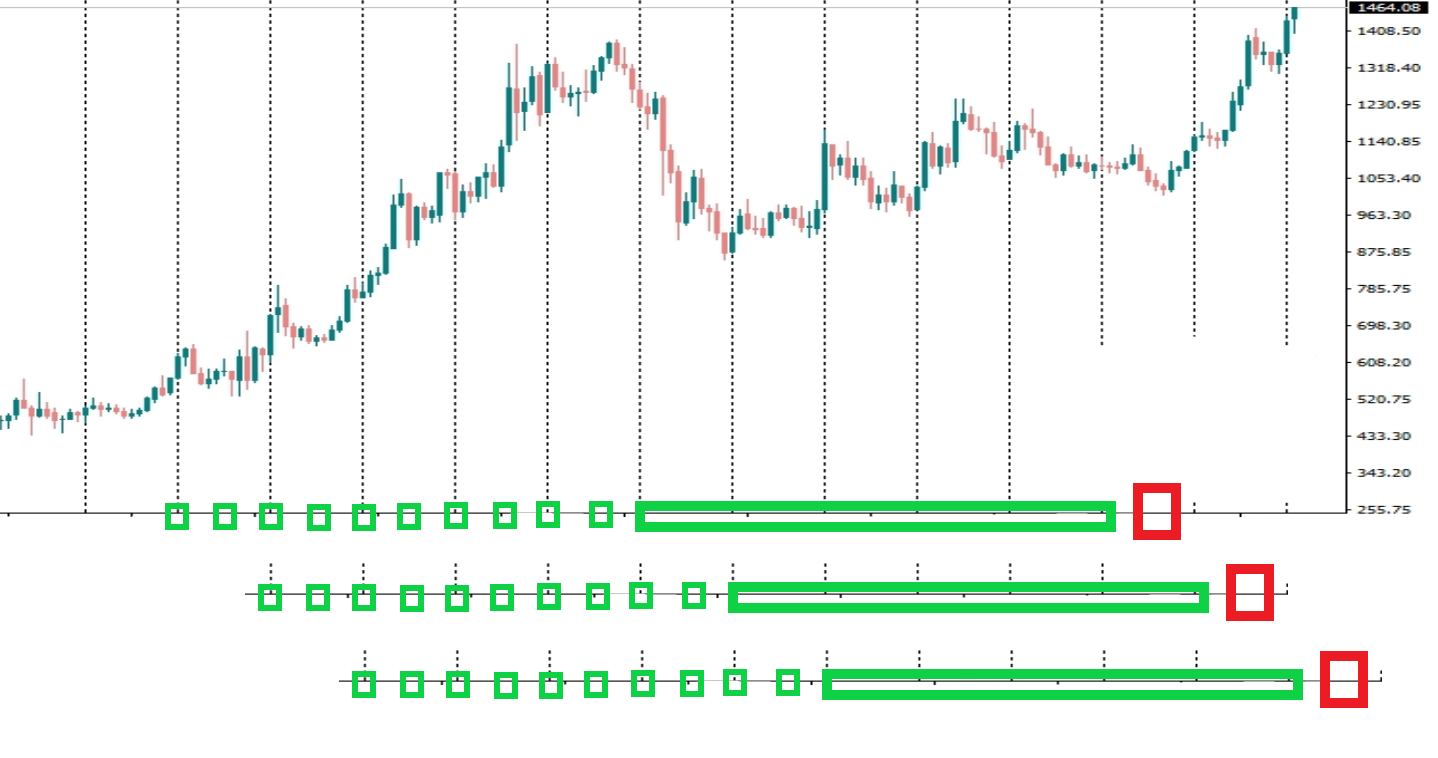

## Подготовка

In [57]:
# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, LSTM, MaxPooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Коллбэк
from tensorflow.keras.callbacks import LearningRateScheduler

# Загрузка датасетов из облака google
import gdown

# Отрисовка графиков
import matplotlib.pyplot as plt

# Отрисовка графики в ячейке colab
%matplotlib inline

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import acf

In [58]:
# Назначение размера и стиля графиков по умолчанию

from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

In [59]:
# Загрузка датасетов из облака

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/16_17.csv', None, quiet=True)
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/18_19.csv', None, quiet=True)

'18_19.csv'

In [60]:
# Чтение данных в таблицы с удалением ненужных столбцов

data16_17 = pd.read_csv('16_17.csv', sep=';').drop(columns=['DATE', 'TIME'])
data18_19 = pd.read_csv('18_19.csv', sep=';').drop(columns=['DATE', 'TIME'])

In [61]:
# Просмотр размерностей получившихся таблиц

print(data16_17.shape)
print(data18_19.shape)

(263925, 5)
(217947, 5)


In [62]:
# Создание общего набора данных из двух датасетов

data = pd.concat([data16_17,data18_19])   # Объединение датасетов
data = data.reset_index(drop = True)      # Обнуление индексов

# Проверка формы данных
print(data.shape)

(481872, 5)


In [63]:
# Получение названий столбцов

col = data.columns
print(col)

Index(['OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME'], dtype='object')


In [64]:
# Задание циклов для столбцов таким образом, чтобы происходил перебор всех возможных пар:
# Перебор индексов массива с именами столбцов 'OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME',
# получая пары 'OPEN' и 'MAX', 'OPEN' и 'MIN', 'OPEN' и 'CLOSE' ..., 'MAX' и 'MIN', 'MAX' и 'CLOSE' и т.д

for i in range(col.shape[0]): # Для всех пар
    for j in range(i + 1 , col.shape[0]): # Расчет
        data[col[i] + '-' + col[j]] = data[col[i]] - data[col[j]] # Разности
        data['|' + col[i] + '-' + col[j] + '|'] = abs(data[col[i]] - data[col[j]]) # Модулей разностей
        data[col[i] + '*' + col[j]] = data[col[i]] * data[col[j]] # Произведения

# Для каждого столбца 'OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME' расчет:
for i in col:
    # Обратные значения. 1e-3 в формуле нужно, чтобы случайно не разделить на 0
    data['Обратный ' + i] = 1 / (data[i] + 1e-3)
    # Создание пустого столбца
    data['Производная от ' + i] = np.nan
    # При помощи срезов расчет первых производных, .reset_index(drop=True) нужен для корректных расчетов
    data['Производная от ' + i][1:] = data[i][1:].reset_index(drop=True) - data[i][:-1].reset_index(drop=True)
    # Создание пустого столбца
    data['Вторая производная от ' + i] = np.nan
    # При помощи срезов расчет вторых производных
    data['Вторая производная от ' + i][2:] = data[i][2:].reset_index(drop=True) - 2 * data[i][1:-1].reset_index(drop=True) + data[i][:-2].reset_index(drop=True)


In [65]:
print(data.columns)

Index(['OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME', 'OPEN-MAX', '|OPEN-MAX|',
       'OPEN*MAX', 'OPEN-MIN', '|OPEN-MIN|', 'OPEN*MIN', 'OPEN-CLOSE',
       '|OPEN-CLOSE|', 'OPEN*CLOSE', 'OPEN-VOLUME', '|OPEN-VOLUME|',
       'OPEN*VOLUME', 'MAX-MIN', '|MAX-MIN|', 'MAX*MIN', 'MAX-CLOSE',
       '|MAX-CLOSE|', 'MAX*CLOSE', 'MAX-VOLUME', '|MAX-VOLUME|', 'MAX*VOLUME',
       'MIN-CLOSE', '|MIN-CLOSE|', 'MIN*CLOSE', 'MIN-VOLUME', '|MIN-VOLUME|',
       'MIN*VOLUME', 'CLOSE-VOLUME', '|CLOSE-VOLUME|', 'CLOSE*VOLUME',
       'Обратный OPEN', 'Производная от OPEN', 'Вторая производная от OPEN',
       'Обратный MAX', 'Производная от MAX', 'Вторая производная от MAX',
       'Обратный MIN', 'Производная от MIN', 'Вторая производная от MIN',
       'Обратный CLOSE', 'Производная от CLOSE', 'Вторая производная от CLOSE',
       'Обратный VOLUME', 'Производная от VOLUME',
       'Вторая производная от VOLUME'],
      dtype='object')


In [66]:
# Просмотр результатов
data

,OPEN,MAX,MIN,CLOSE,VOLUME,OPEN-MAX,|OPEN-MAX|,OPEN*MAX,OPEN-MIN,|OPEN-MIN|,...,Вторая производная от MAX,Обратный MIN,Производная от MIN,Вторая производная от MIN,Обратный CLOSE,Производная от CLOSE,Вторая производная от CLOSE,Обратный VOLUME,Производная от VOLUME,Вторая производная от VOLUME
0,2351.0,2355.8,2350.0,2350.0,2547,-4.8,4.8,5538485.80,1.0,1.0,...,NaN,0.000426,NaN,NaN,0.000426,NaN,NaN,0.000393,NaN,NaN
1,2352.9,2355.7,2350.0,2355.7,195,-2.8,2.8,5542726.53,2.9,2.9,...,NaN,0.000426,0.0,NaN,0.000425,5.7,NaN,0.005128,-2352.0,NaN
2,2355.6,2356.0,2351.4,2354.1,257,-0.4,0.4,5549793.60,4.2,4.2,...,0.4,0.000425,1.4,1.4,0.000425,-1.6,-7.3,0.003891,62.0,2414.0
3,2354.5,2355.0,2351.2,2353.7,763,-0.5,0.5,5544847.50,3.3,3.3,...,-1.3,0.000425,-0.2,-1.6,0.000425,-0.4,1.2,0.001311,506.0,444.0
4,2353.1,2353.9,2353.1,2353.6,231,-0.8,0.8,5538962.09,0.0,0.0,...,-0.1,0.000425,1.9,2.1,0.000425,-0.1,0.3,0.004329,-532.0,-1038.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481867,5183.5,5183.5,5183.5,5183.5,31523,0.0,0.0,26868672.25,0.0,0.0,...,11.5,0.000193,16.0,18.0,0.000193,11.5,10.0,0.000032,29174.0,29480.0
481868,5183.5,5183.5,5183.5,5183.5,5090,0.0,0.0,26868672.25,0.0,0.0,...,-11.5,0.000193,0.0,-16.0,0.000193,0.0,-11.5,0.000196,-26433.0,-55607.0
481869,5183.5,5183.5,5183.5,5183.5,230,0.0,0.0,26868672.25,0.0,0.0,...,0.0,0.000193,0.0,0.0,0.000193,0.0,0.0,0.004348,-4860.0,21573.0
481870,5183.5,5183.5,5183.5,5183.5,5,0.0,0.0,26868672.25,0.0,0.0,...,0.0,0.000193,0.0,0.0,0.000193,0.0,0.0,0.199960,-225.0,4635.0


In [67]:
# Использование всех столбцов, кроме первых двух
data = np.array(data.iloc[2:])

# Переменная, для использования одной и той же архитектуры под разные матрицы
columnsamount = data.shape[1]
print(columnsamount)

50


In [68]:
# Загрузка и предварительная обработка
data16_17 = pd.read_csv('16_17.csv', sep=';').drop(columns=['DATE', 'TIME'])
data18_19 = pd.read_csv('18_19.csv', sep=';').drop(columns=['DATE', 'TIME'])

print(data16_17.shape)
print(data18_19.shape)

# Объединение датасетов
data = pd.concat([data16_17, data18_19]).reset_index(drop=True)

# Проверка формы данных
print(data.shape)

# Выводим названия столбцов
col = data.columns
print(col)

(263925, 5)
(217947, 5)
(481872, 5)
Index(['OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME'], dtype='object')


In [69]:
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, LSTM, MaxPooling1D, Concatenate

# Выбор только нужных базовых признаков
base_cols = ['OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME']
data = data[base_cols].astype(np.float32)

# Добавим только простые производные (1-я и 2-я)
for col in base_cols:
    data[f'd_{col}'] = data[col].diff()
    data[f'd2_{col}'] = data[col].diff().diff()

# Удалим пропуски
data = data.dropna().reset_index(drop=True)

# Преобразование в массив
values = data.values.astype(np.float32)

In [70]:
# Нормализация
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

close_idx = base_cols.index('CLOSE')
X = np.hstack((values[:, :close_idx], values[:, close_idx+1:]))
y = values[:, close_idx:close_idx+1]

X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

In [71]:
# Последовательности
SEQ_SHORT, SEQ_LONG = 50, 50

In [72]:
def make_seq(data, steps, step_size):
    res = []
    for i in range(steps * step_size, len(data)):
        idx = [i - j * step_size for j in range(steps)][::-1]
        res.append(data[idx])
    return np.array(res, dtype=np.float32)

X1 = make_seq(X_scaled, SEQ_SHORT, 1)
X2 = make_seq(X_scaled, SEQ_LONG, 10)
y_seq = y_scaled[SEQ_SHORT * 10:]

min_len = min(len(X1), len(X2), len(y_seq))
X1, X2, y_seq = X1[-min_len:], X2[-min_len:], y_seq[-min_len:]

In [73]:
# Простая модель
inp1 = Input(shape=(SEQ_SHORT, X1.shape[2]))
inp2 = Input(shape=(SEQ_LONG, X2.shape[2]))
x1 = Conv1D(16, 3, activation='relu')(inp1)
x2 = Conv1D(16, 3, activation='relu')(inp2)
x1 = Flatten()(x1)
x2 = Flatten()(x2)
x = Concatenate()([x1, x2])
x = Dense(32, activation='relu')(x)
out = Dense(1)(x)

model = Model([inp1, inp2], out)
model.compile(optimizer='adam', loss='mse')

In [74]:
# Обучение
history = model.fit(
    [X1, X2], y_seq,
    epochs=10,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)

Epoch 1/10
27078/27078 ━━━━━━━━━━━━━━━━━━━━ 79s 3ms/step - loss: 0.0016 - val_loss: 7.8931e-04
Epoch 2/10
27078/27078 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - loss: 8.5753e-06 - val_loss: 1.7690e-05
Epoch 3/10
27078/27078 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 5.8447e-06 - val_loss: 1.1582e-04
Epoch 4/10
27078/27078 ━━━━━━━━━━━━━━━━━━━━ 76s 3ms/step - loss: 4.1866e-06 - val_loss: 5.3439e-05
Epoch 5/10
27078/27078 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - loss: 3.0081e-06 - val_loss: 9.0178e-06
Epoch 6/10
27078/27078 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 2.5562e-06 - val_loss: 3.7247e-05
Epoch 7/10
27078/27078 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - loss: 2.3190e-06 - val_loss: 1.1347e-04
Epoch 8/10
27078/27078 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 2.1113e-06 - val_loss: 1.1595e-06
Epoch 9/10
27078/27078 ━━━━━━━━━━━━━━━━━━━━ 78s 3ms/step - loss: 1.7954e-06 - val_loss: 3.4025e-06
Epoch 10/10
27078/27078 ━━━━━━━━━━━━━━━━━━━━ 78s 3ms/step - loss: 1.6455e-06 - val_loss: 9.9564e-05


In [75]:
def plot_learning_curve(history, title='График процесса обучения'):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(14, 6))
    plt.plot(history.history['loss'], label='Ошибка на обучающем наборе', color='blue')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Ошибка на валидации', color='orange')
    plt.title(title)
    plt.xlabel('Эпоха')
    plt.ylabel('Среднеквадратичная ошибка (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

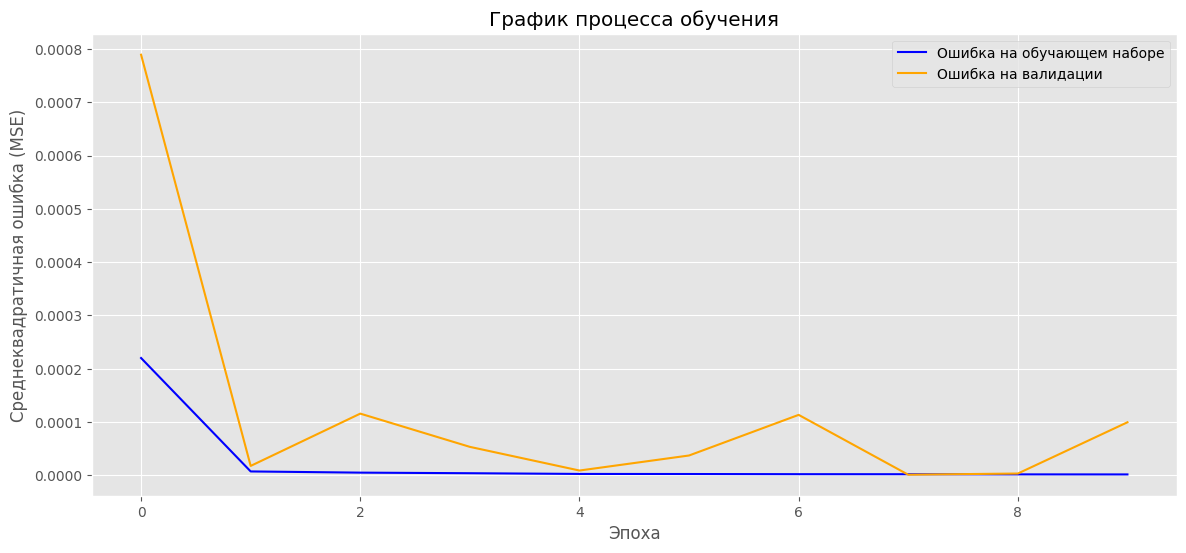

In [76]:
# График обучения
plot_learning_curve(history)

In [77]:
import matplotlib.pyplot as plt
import numpy as np

def eval_net(model, X1, X2, y_scaled, y_scaler, lags=50):
    """
    Оценка модели:
    - График предсказания vs факт
    - График корреляции ошибок по лагам
    """
    # Предсказания
    y_pred_scaled = model.predict([X1, X2], verbose=0)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    y_true = y_scaler.inverse_transform(y_scaled)

    # График фактических vs прогнозных
    plt.figure(figsize=(14, 6))
    plt.plot(y_true, label='Факт', color='blue')
    plt.plot(y_pred, label='Прогноз', color='red', alpha=0.7)
    plt.title('Фактические и прогнозные значения')
    plt.xlabel('Временной шаг')
    plt.ylabel('CLOSE')
    plt.legend()
    plt.grid(True)
    plt.show()

    # График корреляции с лагами
    def correlate(a, b):
        return np.corrcoef(a, b)[0, 1]

    steps = range(1, min(lags + 1, len(y_true) // 2))
    cross_corr = [correlate(y_true[:-s, 0], y_pred[s:, 0]) for s in steps]
    auto_corr = [correlate(y_true[:-s, 0], y_true[s:, 0]) for s in steps]

    plt.figure(figsize=(14, 6))
    plt.plot(steps, cross_corr, label='Прогноз vs Факт')
    plt.plot(steps, auto_corr, label='Автокорреляция факта')
    plt.title('Корреляция предсказаний и факта с лагами')
    plt.xlabel('Лаг')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.grid(True)
    plt.show()


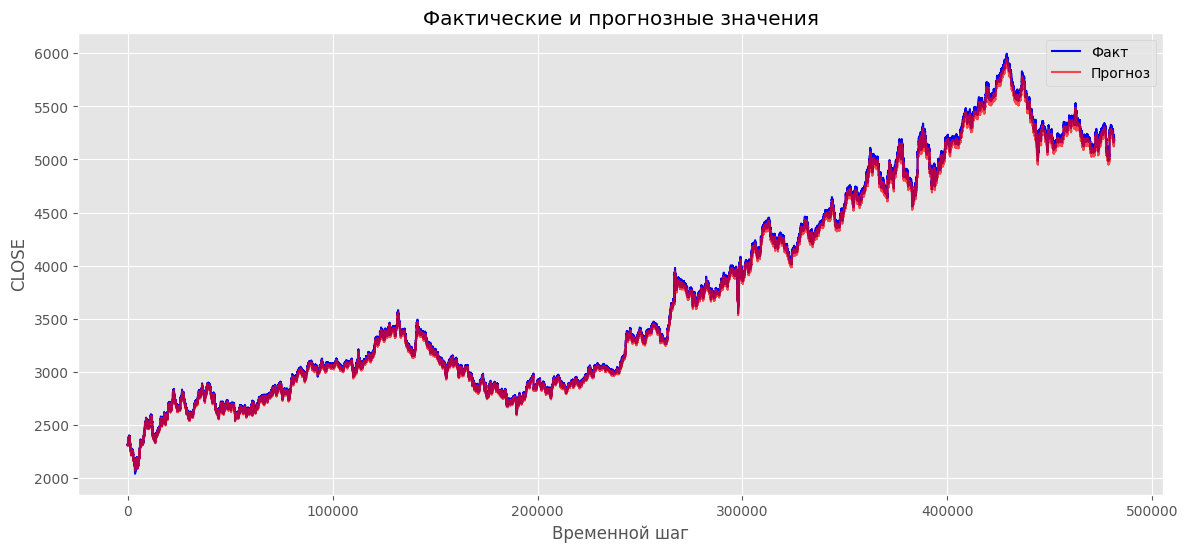

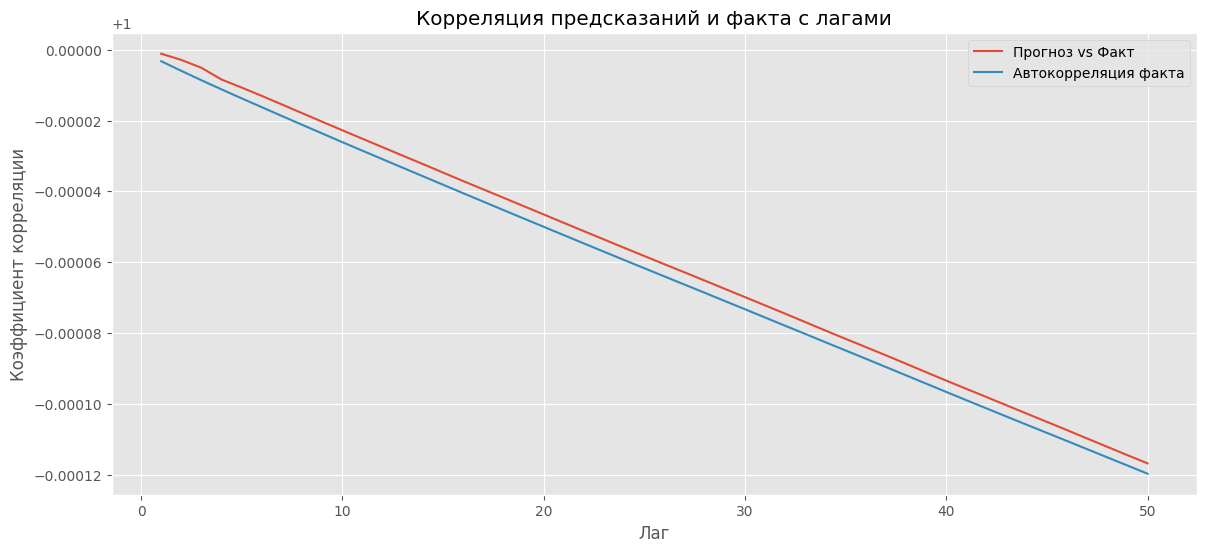

In [78]:
eval_net(model, X1, X2, y_seq, y_scaler)